***
# <font color=red>Building and Explaining a Classifier using AutoMLx</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle AutoMLx Team </font></p>

***

AutoMLx Classification Demo version 23.4.1.

Copyright © 2023, Oracle and/or its affiliates.

Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl/

## Overview of this Notebook

In this notebook we will build a classifier using the Oracle AutoMLx tool for the public Census Income dataset. The dataset is a binary classification dataset, and more details about the dataset can be found at https://archive.ics.uci.edu/ml/datasets/Adult.
We explore the various options provided by the Oracle AutoMLx tool, allowing the user to exercise control over the AutoMLx training process. We then evaluate the different models trained by AutoMLx. Finally we provide an overview of the possibilites that Oracle AutoMLx offers for explaining the predictions of the tuned model.

---
## Prerequisites

  - Experience level: Novice (Python and Machine Learning)
  - Professional experience: Some industry experience
  
Compatible conda pack: [Oracle AutoMLx v23.4 for CPU on Python 3.10 (version 1.0)](oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/Oracle_AutoMLx_v23.4_for_CPU_on_Python_3.10/1.0/automlx234_p310_cpu_x86_64_v1)

---

## Business Use

Data analytics and modeling problems using Machine Learning (ML) are becoming popular and often rely on data science expertise to build accurate ML models. Such modeling tasks primarily involve the following steps:
- Preprocess dataset (clean, impute, engineer features, normalize).
- Pick an appropriate model for the given dataset and prediction task at hand.
- Tune the chosen model’s hyperparameters for the given dataset.

All of these steps are significantly time consuming and heavily rely on data scientist expertise. Unfortunately, to make this problem harder, the best feature subset, model, and hyperparameter choice widely varies with the dataset and the prediction task. Hence, there is no one-size-fits-all solution to achieve reasonably good model performance. Using a simple Python API, AutoMLx can quickly (faster) jump-start the datascience process with an accurately-tuned model and appropriate features for a given prediction task.

## Table of Contents

- <a href='#setup'>0. Setup</a>
- <a href='#load-data'>1. Load the Census Income dataset</a>
- <a href='#AutoMLx'>2. AutoMLx</a>
  - <a href='#Engine'>2.0. Set the engine and deprecation warnings</a>
  - <a href='#provider'>2.1. Create an Instance of Oracle AutoMLx</a>
  - <a href='#default'>2.2. Train a Model using AutoMLx</a>
  - <a href='#analyze'>2.3. Analyze the AutoMLx optimization process </a>
      - <a href='#algorithm-selection'>2.3.1. Algorithm Selection</a>
      - <a href='#adaptive-sampling'>2.3.2. Adaptive Sampling</a>
      - <a href='#feature-selection'>2.3.3. Feature Selection</a>
      - <a href='#hyperparameter-tuning'>2.3.4. Hyperparameter Tuning</a>
      - <a href='#confusion-matrix'>2.3.5. Confusion Matrix</a>
  - <a href='#analyze'>2.3. Analyze the AutoMLx optimization process </a>
      - <a href='#modellist'>2.4. Provide a Specific Model List to AutoMLx</a>
      - <a href='#nalgostuned'>2.5. Increase the number of tuned models</a>
      - <a href='#scoringstr'>2.6. Specify a Different Scoring Metric to AutoMLx</a>
      - <a href='#scoringfn'>2.7. Specify a User-defined Scoring Function to AutoMLx</a>
      - <a href='#timebudget'>2.8. Specify a time budget to AutoMLx</a>
      - <a href='#minfeatures'>2.9. Specify a minimum set of features to AutoMLx</a>
- <a href='#MLX'>3. Machine Learning Explainability (MLX)</a>
  - <a href='#MLX-initializing'> 3.1. Initialize an MLExplainer</a>
  - <a href='#MLX-global'>3.2. Model Explanations (Global Feature Importance)</a>
  - <a href='#MLX-dependency'>3.3. Feature Dependence Explanations (PDP + ICE)</a>
  - <a href='#MLX-local'>3.4. Prediction Explanations (Local Feature Importance)</a>
       - <a href='#MLX-alfi'>3.4.1. Aggregate Local Feature Importance</a>
  - <a href='#MLX-whatif'>3.5. Interactive What-If Explainers</a>
  - <a href='#Counterfactuals'>3.5. Counterfactual Explanations</a>
  - <a href='#MLX-advanced'>3.6. Advanced Feature Importance Options</a>
       - <a href='#MLX-changing'>3.6.1. Change the number of iterations</a>
       - <a href='#MLX-including'>3.6.2. Include the effects of feature interactions (with Shapley feature importance)</a>
       - <a href='#MLX-explain'>3.6.3. Explain the model or explain the world</a>
       - <a href='#MLX-surrogates'>3.6.4. Local explanations with surrogate models (LIME+)</a>
  - <a href='#MLX-advanced-ale'>3.7. Advanced Feature Dependence Options (ALE)</a>
- <a href='#ref'>References</a>

<a id='setup'></a>
## Setup

Basic setup for the Notebook.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Load the required modules.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_selector as selector
import time
import datetime

# Settings for plots
plt.rcParams["figure.figsize"] = [10, 7]
plt.rcParams["font.size"] = 15

# Deprecated automl check
try:
    import automl

    print(
        "⚠️  The 'automl' module is no longer supported. Please update your conda environment to use latest supported version of AutoMLx to run this notebook."
    )
except ImportError:
    pass

# Recommended AutoMLx
import automlx
from automlx import init

<a id='load-data'></a>
## Load the Census Income dataset
We start by reading in the dataset from OpenML.

In [ ]:
dataset = fetch_openml(name="adult", version=1, as_frame=True)
df, y = dataset.data, dataset.target

Lets look at a few of the values in the data

In [4]:
df.head()

age         workclass    fnlwgt  education  education-num  \
0   2         State-gov   77516.0  Bachelors           13.0   
1   3  Self-emp-not-inc   83311.0  Bachelors           13.0   
2   2           Private  215646.0    HS-grad            9.0   
3   3           Private  234721.0       11th            7.0   
4   1           Private  338409.0  Bachelors           13.0   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

  capitalgain capitalloss hoursperweek native-country  
0           1           0            2  United-States  
1           0           0            0  United-States  
2           0           0            2  United-States  
3           0           0            2  United-States  
4           0           0            2           Cuba

The Adult dataset contains a mix of numerical and string data, making it a challenging problem to train machine learning models on.

In [ ]:
pd.DataFrame({"Data type": df.dtypes}).T

age workclass   fnlwgt education education-num marital-status  \
Data type  category  category  float64  category       float64       category   

          occupation relationship      race       sex capitalgain capitalloss  \
Data type   category     category  category  category    category    category   

          hoursperweek native-country  
Data type     category       category

The dataset also contains a lot of missing values. The Oracle AutoMLx solution automatically handles missing values by dropping features with too many missing values, and filling in the remaining missing values based on the feature type.

In [ ]:
pd.DataFrame({"% missing values": df.isnull().sum() * 100 / len(df)}).T

age  workclass  fnlwgt  education  education-num  \
% missing values  0.0   5.730724     0.0        0.0            0.0   

                  marital-status  occupation  relationship  race  sex  \
% missing values             0.0    5.751198           0.0   0.0  0.0   

                  capitalgain  capitalloss  hoursperweek  native-country  
% missing values          0.0          0.0           0.0        1.754637

We visualize the distribution of the target variable in the training data.

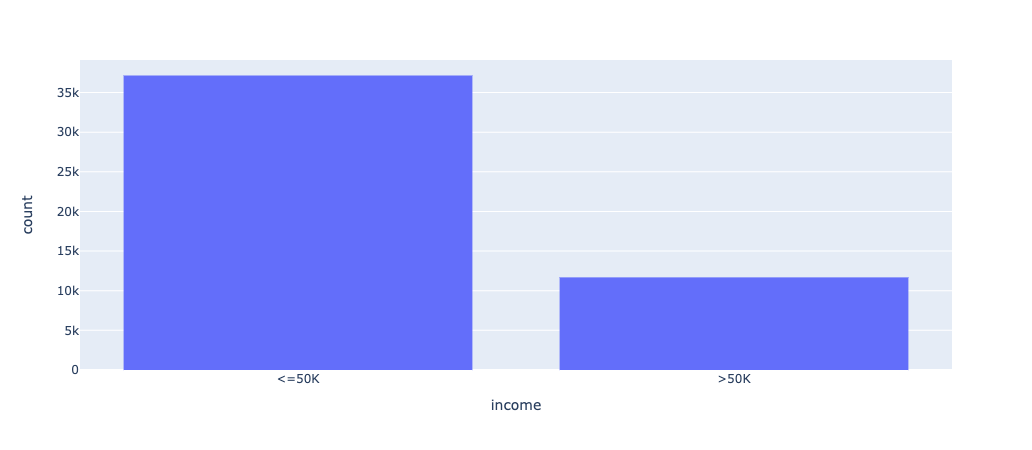

In [ ]:
y_df = pd.DataFrame(y)
y_df.columns = ["income"]

fig = px.histogram(y_df, x="income")
fig.show()

We now separate the predictions (`y`) from the training data (`X`) for both the training (70%) and test (30%) datasets. The training set will be used to create a Machine Learning model using AutoMLx, and the test set will be used to evaluate the model's performance on unseen data.

In [ ]:
# Several of the columns are incorrectly labeled as category type in the original dataset
numeric_columns = ["age", "capitalgain", "capitalloss", "hoursperweek"]
for col in df.columns:
    if col in numeric_columns:
        df[col] = df[col].astype(int)


X_train, X_test, y_train, y_test = train_test_split(
    df, y.map({">50K": 1, "<=50K": 0}).astype(int), train_size=0.7, random_state=0
)

X_train.shape, X_test.shape

((34189, 14), (14653, 14))

<a id='AutoMLx'></a>
## AutoMLx

<a id='Engine'></a>
### Setting the engine and deprecation warnings
The AutoMLx pipeline offers the function `init`, which allows to initialize the parallelization engine. 

In [ ]:
init(engine="ray")

[2024-01-12 10:46:35,466] [automlx.backend] Overwriting ray session directory to /tmp/9y5v9u5y/ray, which will be deleted at engine shutdown. If you wish to retain ray logs, provide _temp_dir in ray_setup dict of engine_opts when initializing the AutoMLx engine.


<a id='provider'></a>
### Create an instance of Oracle AutoMLx

The Oracle AutoMLx solution provides a pipeline that automatically finds a tuned model given a prediction task and a training dataset. In particular it allows to find a tuned model for any supervised prediction task, e.g. classification or regression where the target can be binary, categorical or real-valued.

AutoMLx consists of five main modules: 
- **Preprocessing** : Clean, impute, engineer, and normalize features.
- **Algorithm Selection** : Identify the right classification algorithm -in this notebook- for a given dataset, choosing from amongst:
    - AdaBoostClassifier
    - DecisionTreeClassifier
    - ExtraTreesClassifier
    - TorchMLPClassifier
    - KNeighborsClassifier
    - LGBMClassifier
    - LinearSVC
    - LogisticRegression
    - RandomForestClassifier
    - SVC
    - XGBClassifier
    - GaussianNB
- **Adaptive Sampling** : Select a subset of the data samples for the model to be trained on.
- **Feature Selection** : Select a subset of the data features, based on the previously selected model.
- **Hyperparameter Tuning** : Find the right model parameters that maximize score for the given dataset. 

All these pieces are readily combined into a simple AutoMLx pipeline which automates the entire Machine Learning process with minimal user input/interaction.

<a id='default'></a>
### Train a model using AutoMLx

The AutoMLx API is quite simple to work with. We create an instance of the pipeline. Next, the training data is passed to the `fit()` function which executes the previously mentioned steps.

In [ ]:
est1 = automlx.Pipeline(task="classification")
est1.fit(X_train, y_train)

[2024-01-12 10:46:39,849] [automlx.interface] Dataset shape: (34189,14)
[2024-01-12 10:46:39,994] [automlx.data_transform] Running preprocessing. Number of features: 15
[2024-01-12 10:46:40,364] [automlx.data_transform] Preprocessing completed. Took 0.370 secs
[2024-01-12 10:46:40,597] [automlx.process] Running Model Generation
[2024-01-12 10:46:40,687] [automlx.process] KNeighborsClassifier is disabled. The KNeighborsClassifier model is only recommended for datasets with less than 10000 samples and 1000 features.
[2024-01-12 10:46:40,689] [automlx.process] SVC is disabled. The SVC model is only recommended for datasets with less than 10000 samples and 1000 features.
[2024-01-12 10:46:40,691] [automlx.process] Package torch is not installed. Removing models [<automlx._model.pytorch.mlp.TorchMLPClassifier object at 0x7f87687150c0>] from generated model list.
[2024-01-12 10:46:40,693] [automlx.process] Model Generation completed.
[2024-01-12 10:46:40,710] [automlx.model_selection] Runnin

A model is then generated (`est1`) and can be used for prediction tasks. We use the `roc_auc_score` scoring metric to evaluate the performance of this model on unseen data (`X_test`).

In [ ]:
y_proba = est1.predict_proba(X_test)
score_default = roc_auc_score(y_test, y_proba[:, 1])

print(f"Score on test data : {score_default}")

Score on test data : 0.9114323983285756


<a id='analyze'></a>
### Analyze the AutoMLx optimization process

During the AutoMLx process, a summary of the optimization process is logged. It consists of:
- Information about the training data .
- Information about the AutoMLx Pipeline, such as:
    - Selected features that AutoMLx found to be most predictive in the training data;
    - Selected algorithm that was the best choice for this data;
    - Selected hyperparameters for the selected algorithm.

AutoMLx provides a `print_summary` API to output all the different trials performed.

In [12]:
est1.print_summary()

Training Dataset size     (34189, 14)                                                                                                                                                                         
Validation Dataset size   None                                                                                                                                                                                
CV                        KFoldSplit(Shuffle=True, Seed=7, folds=5, stratify by=target)                                                                                                                       
Optimization Metric       neg_log_loss                                                                                                                                                                        
Selected Algorithm        XGBClassifier                                                                                                                                                                       
Selected Hyperparameters  {'learning_rate': 0.1, 'min_child_weight': 1, 'max_depth': 3, 'reg_alpha': 3.976405853312976, 'booster': 'gbtree', 'reg_lambda': 1, 'n_estimators': 275, 'use_label_encoder': False}
AutoMLx version           23.4.1                                                                                                                                                                              
Python version            3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]

Step # Samples  # Features  \
0    Model Selection    4000      15           
1    Model Selection    4000      15           
2    Model Selection    4000      15           
3    Model Selection    4000      15           
4    Model Selection    4000      15           
5    Model Selection    4000      15           
6    Model Selection    4000      15           
7    Model Selection    None      0            
8    Adaptive Sampling  12342     15           
9    Adaptive Sampling  6730      15           
10   Adaptive Sampling  9906      15           
11   Adaptive Sampling  3668      15           
12   Adaptive Sampling  2000      15           
13   Adaptive Sampling  None      0            
14   Feature Selection  12223     12           
15   Feature Selection  12223     13           
16   Feature Selection  12222     15           
17   Feature Selection  12223     12           
18   Feature Selection  12223     10           
19   Feature Selection  12223     10           
20   Feature Selection  12223     12           
21   Feature Selection  12223     12           
22   Feature Selection  12223     10           
23   Feature Selection  12223     10           
24   Feature Selection  12223     8            
25   Feature Selection  12223     8            
26   Feature Selection  12223     12           
27   Feature Selection  12223     10           
28   Feature Selection  12223     8            
29   Feature Selection  12223     8            
30   Feature Selection  12223     6            
31   Feature Selection  12223     6            
32   Feature Selection  12223     5            
33   Feature Selection  12223     6            
34   Feature Selection  12223     5            
35   Feature Selection  12223     6            
36   Feature Selection  12223     5            
37   Feature Selection  12223     4            
38   Feature Selection  12223     4            
39   Feature Selection  12223     5            
40   Feature Selection  12223     4            
41   Feature Selection  12223     4            
42   Feature Selection  12223     3            
43   Feature Selection  12223     6            
44   Feature Selection  12223     5            
45   Feature Selection  12223     3            
46   Feature Selection  12223     3            
47   Feature Selection  12223     4            
48   Feature Selection  12223     3            
49   Feature Selection  12223     2            
50   Feature Selection  12223     3            
51   Feature Selection  12223     2            
52   Feature Selection  12223     2            
53   Feature Selection  12223     1            
54   Feature Selection  12223     1            
55   Model Tuning       12223     12           
56   Model Tuning       12223     12           
57   Model Tuning       12223     12           
58   Model Tuning       12223     12           
59   Model Tuning       12223     12           
60   Model Tuning       12223     12           
61   Model Tuning       12223     12           
62   Model Tuning       12223     12           
63   Model Tuning       12223     12           
64   Model Tuning       12223     12           
65   Model Tuning       12223     12           
66   Model Tuning       12223     12           
67   Model Tuning       12223     12           
68   Model Tuning       12223     12           
69   Model Tuning       12223     12           
70   Model Tuning       12223     12           
71   Model Tuning       12223     12           
72   Model Tuning       12223     12           
73   Model Tuning       12223     12           
74   Model Tuning       12223     12           
75   Model Tuning       12223     12           
76   Model Tuning       12223     12           
77   Model Tuning       12223     12           
78   Model Tuning       12223     12           
79   Model Tuning       12223     12           
80   Model Tuning       12223     12           
81   Model Tuning       12223     12           
82   Model Tuning       12223     

We also provide the capability to visualize the results of each stage of the AutoMLx pipeline. 

<a id='algorithm-selection'></a>
#### Algorithm Selection

The plot below shows the scores predicted by Algorithm Selection for each algorithm. The horizontal line shows the average score across all algorithms. Algorithms below the line are colored turquoise, whereas those with a score higher than the mean are colored teal. Here we can see that the `LGBMClassifier` achieved the highest predicted score (orange bar), and is chosen for subsequent stages of the Pipeline.

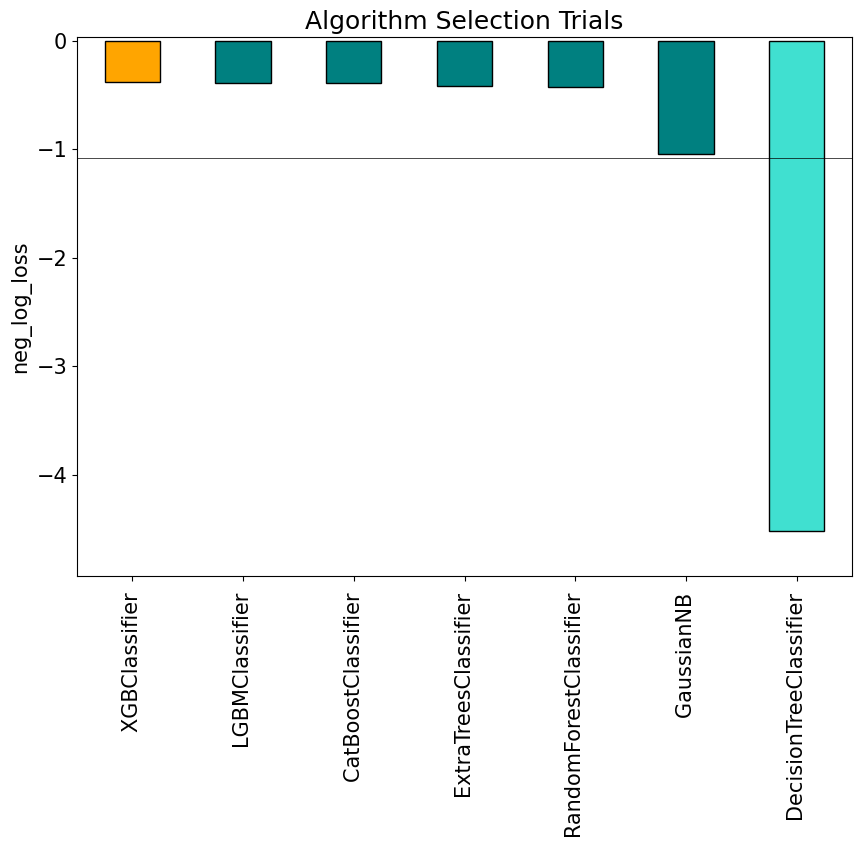

In [ ]:
# Each trial is a row in a dataframe that contains
# Algorithm, Number of Samples, Number of Features, Hyperparameters, Score, Runtime, Memory Usage, Step as features
trials = est1.completed_trials_summary_[
    est1.completed_trials_summary_["Step"].str.contains("Model Selection")
]
name_of_score_column = f"Score ({est1._inferred_score_metric[0].name})"
trials.replace([np.inf, -np.inf], np.nan, inplace=True)
trials.dropna(subset=[name_of_score_column], inplace=True)
scores = trials[name_of_score_column].tolist()
models = trials["Algorithm"].tolist()
colors = []

y_margin = 0.10 * (max(scores) - min(scores))
s = pd.Series(scores, index=models).sort_values(ascending=False)
s = s.dropna()
for f in s.keys():
    if f.strip() == est1.selected_model_.strip():
        colors.append("orange")
    elif s[f] >= s.mean():
        colors.append("teal")
    else:
        colors.append("turquoise")

fig, ax = plt.subplots(1)
ax.set_title("Algorithm Selection Trials")
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.set_ylabel(est1._inferred_score_metric[0].name)
s.plot.bar(ax=ax, color=colors, edgecolor="black")
ax.axhline(y=s.mean(), color="black", linewidth=0.5)
plt.show()

<a id='adaptive-sampling'></a>
#### Adaptive Sampling

Following Algorithm Selection, Adaptive Sampling aims to find the smallest dataset sample that can be created without compromising validation set score for the chosen model (`LGBMClassifier`). In this case, no subset is found to keep sufficient validation score, so we continue with the entire dataset.

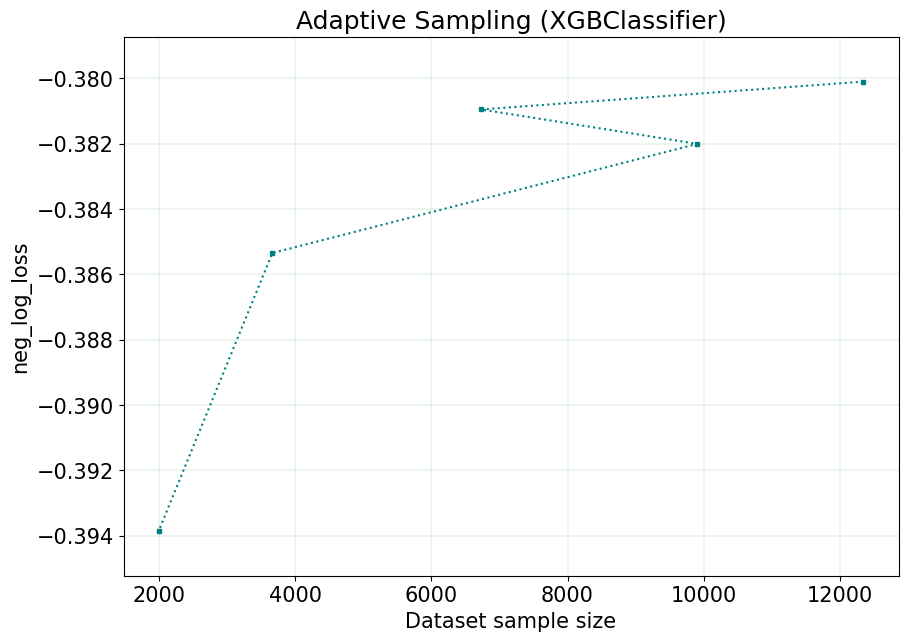

In [ ]:
# Each trial is a row in a dataframe that contains
# Algorithm, Number of Samples, Number of Features, Hyperparameters, Score, Runtime, Memory Usage, Step as features
trials = est1.completed_trials_summary_[
    est1.completed_trials_summary_["Step"].str.contains("Adaptive Sampling")
]
trials.replace([np.inf, -np.inf], np.nan, inplace=True)
trials.dropna(subset=[name_of_score_column], inplace=True)
scores = trials[name_of_score_column].tolist()
n_samples = trials["# Samples"].tolist()

y_margin = 0.10 * (max(scores) - min(scores))
fig, ax = plt.subplots(1)
ax.set_title("Adaptive Sampling ({})".format(est1.selected_model_))
ax.set_xlabel("Dataset sample size")
ax.set_ylabel(est1._inferred_score_metric[0].name)
ax.grid(color="g", linestyle="-", linewidth=0.1)
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.plot(n_samples, scores, "k:", marker="s", color="teal", markersize=3)
plt.show()

<a id='feature-selection'></a>
#### Feature Selection

After finding a sample subset, the next step is to find a relevant feature subset to maximize score for the chosen algorithm. AutoMLx Feature Selection follows an intelligent search strategy, looking at various possible feature rankings and subsets, and identifying that smallest feature subset that does not compromise on score for the chosen algorithm (`LGBMClassifier`). The orange line shows the optimal number of features chosen by Feature Selection (in this case 11 features, droppping `fnlwgt`, `education`, `race` and `native-country`).

Features selected: ['age', 'capitalgain', 'capitalloss', 'education-num', 'fnlwgt', 'hoursperweek', 'marital-status', 'occupation', 'race', 'relationship', 'sex_1', 'workclass']
Features dropped: ['education', 'native-country']


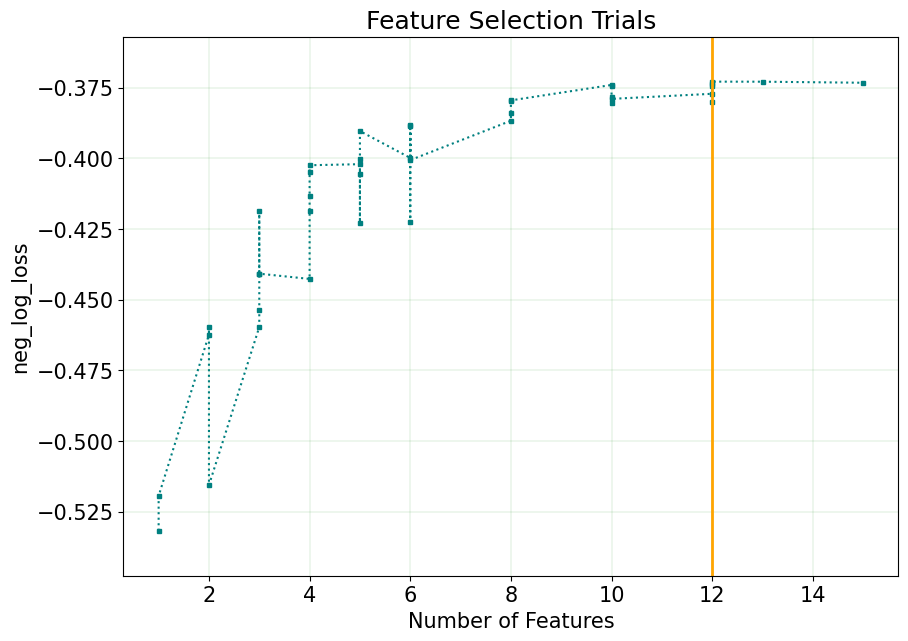

In [ ]:
print(f"Features selected: {est1.selected_features_names_}")
dropped_features = df.drop(est1.selected_features_names_raw_, axis=1).columns
print(f"Features dropped: {dropped_features.to_list()}")

# Each trial is a row in a dataframe that contains
# Algorithm, Number of Samples, Number of Features, Hyperparameters, Score, Runtime, Memory Usage, Step as features
trials = est1.completed_trials_summary_[
    est1.completed_trials_summary_["Step"].str.contains("Feature Selection")
]
trials.replace([np.inf, -np.inf], np.nan, inplace=True)
trials.dropna(subset=[name_of_score_column], inplace=True)
trials.sort_values(by=["# Features"], ascending=True, inplace=True)
scores = trials[name_of_score_column].tolist()
n_features = trials["# Features"].tolist()

y_margin = 0.10 * (max(scores) - min(scores))
fig, ax = plt.subplots(1)
ax.set_title("Feature Selection Trials")
ax.set_xlabel("Number of Features")
ax.set_ylabel(est1._inferred_score_metric[0].name)
ax.grid(color="g", linestyle="-", linewidth=0.1)
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.plot(n_features, scores, "k:", marker="s", color="teal", markersize=3)
ax.axvline(x=len(est1.selected_features_names_), color="orange", linewidth=2.0)
plt.show()

<a id='hyperparameter-tuning'></a>
#### Hyperparameter Tuning

Hyperparameter Tuning is the last stage of the AutoMLx pipeline, and focuses on improving the chosen algorithm's score on the reduced dataset (after Adaptive Sampling and Feature Selection). We use a novel algorithm to search across many hyperparameters dimensions, and converge automatically when optimal hyperparameters are identified. Each trial in the graph below represents a particular hyperparameters configuration for the selected model.

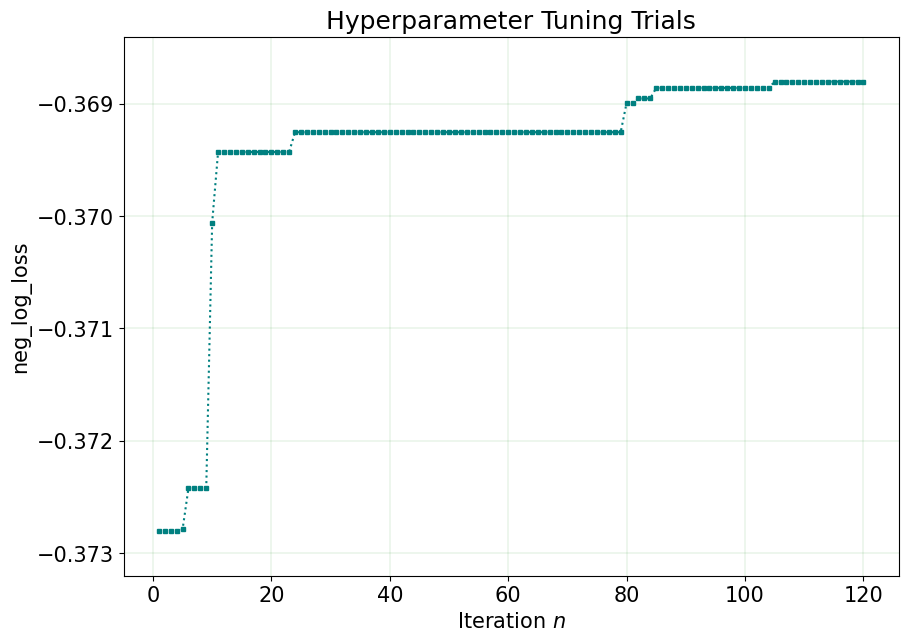

In [ ]:
# Each trial is a row in a dataframe that contains
# Algorithm, Number of Samples, Number of Features, Hyperparameters, Score, Runtime, Memory Usage, Step as features
trials = est1.completed_trials_summary_[
    est1.completed_trials_summary_["Step"].str.contains("Model Tuning")
]
trials.replace([np.inf, -np.inf], np.nan, inplace=True)
trials.dropna(subset=[name_of_score_column], inplace=True)
trials.drop(trials[trials["Finished"] == -1].index, inplace=True)
trials["Finished"] = trials["Finished"].apply(
    lambda x: time.mktime(
        datetime.datetime.strptime(x, "%a %b %d %H:%M:%S %Y").timetuple()
    )
)
trials.sort_values(by=["Finished"], ascending=True, inplace=True)
scores = trials[name_of_score_column].tolist()
score = []
score.append(scores[0])
for i in range(1, len(scores)):
    if scores[i] >= score[i - 1]:
        score.append(scores[i])
    else:
        score.append(score[i - 1])
y_margin = 0.10 * (max(score) - min(score))

fig, ax = plt.subplots(1)
ax.set_title("Hyperparameter Tuning Trials")
ax.set_xlabel("Iteration $n$")
ax.set_ylabel(est1._inferred_score_metric[0].name)
ax.grid(color="g", linestyle="-", linewidth=0.1)
ax.set_ylim(min(score) - y_margin, max(score) + y_margin)
ax.plot(range(1, len(trials) + 1), score, "k:", marker="s", color="teal", markersize=3)
plt.show()

<a id='confusion-matrix'></a>
#### Confusion Matrix

We can use a Confusion Matrix to help us visualize the model's behavior. Note that the displayed confusion matrix represents percentages.

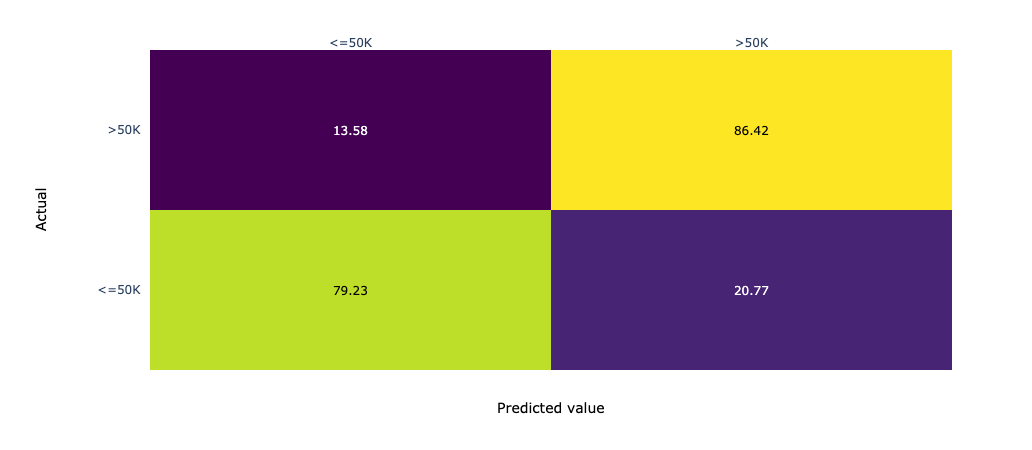

In [ ]:
y_pred = est1.predict(X_test)
cm = confusion_matrix(y_test.astype(int), y_pred, labels=[False, True])
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

text = [[f"{y*100:.2f}" for y in x] for x in cm]
fig = ff.create_annotated_heatmap(
    cm,
    x=["<=50K", ">50K"],
    y=["<=50K", ">50K"],
    annotation_text=text,
    colorscale="Viridis",
)
fig.add_annotation(
    dict(
        font=dict(color="black", size=14),
        x=0.5,
        y=-0.15,
        showarrow=False,
        text="Predicted value",
        xref="paper",
        yref="paper",
    )
)

fig.add_annotation(
    dict(
        font=dict(color="black", size=14),
        x=-0.15,
        y=0.5,
        showarrow=False,
        text="Actual",
        textangle=-90,
        xref="paper",
        yref="paper",
    )
)
fig.update_layout(margin=dict(t=50, l=150))
fig.show()

<a id='modellist'></a>
### Advanced AutoMLx Configuration

You can also configure the pipeline with suitable parameters according to your needs.

In [ ]:
custom_pipeline = automlx.Pipeline(
    task="classification",  # Supports 'regression', 'anomaly_detection', 'forecasting'
    model_list=[  # Specify the models you want the AutoMLx to consider
        "LogisticRegression",
        "LGBMClassifier",
        "GaussianNB",
    ],
    n_algos_tuned=2,  # Choose how many models to tune
    min_features=[  # Specify minimum features to force the model to use. It can take 3 possible types of values:
        "native-country",  # If int, 0 < min_features <= n_features,
        "marital-status",  # If float, 0 < min_features <= 1.0, 1.0 means disabling feature selection
        "education-num",  # If list, names of features to keep, for example ['a', 'b'] means keep features 'a' and 'b'
    ],
    adaptive_sampling=False,  # Disable or enable Adaptive Sampling step. Default to `True`
    preprocessing=True,  # Disable or enable Preprocessing step. Default to `True`
    search_space={  # You can specify the hyper-parameters and ranges we search
        "LGBMClassifier": {
            "learning_rate": {"range": [0.01, 10], "type": "continuous"},
            "boosting_type": {"range": ["gbdt", "dart"], "type": "categorical"},
        },
    },
    max_tuning_trials=2,  # The maximum number of tuning trials. Can be integer or Dict (max number for each model)
    score_metric="f1_macro",  # Any scikit-learn metric or a custom function
)

<a id='custom-validation'></a>
### Use a custom validation set
You can specify a custom validation set that you want AutoML to use to evaluate the quality of models and configurations. 


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, train_size=0.7, random_state=0
)

A few of the advanced settings can be passed directly to the pipeline's fit method, instead of its constructor.

In [ ]:
custom_pipeline.fit(
    X_train,
    y_train,
    X_val,
    y_val,
    time_budget=20,  # Specify time budget in seconds
    cv="auto",  # Automatically pick a good cross-validation (cv) strategy for the user's dataset.
    # Ignored if X_valid and y_valid are provided.
    # Can also be:
    #   - An integer (For example, to use 5-fold cross validation)
    #   - A list of data indices to use as splits (for advanced, such as time-based splitting)
)
y_proba = custom_pipeline.predict_proba(X_test)
score_modellist = roc_auc_score(y_test, y_proba[:, 1])

print(f"ROC AUC Score on test data : {score_modellist}")

[2024-01-12 11:28:51,179] [automlx.interface] Dataset shape: (34189,14)
[2024-01-12 11:28:51,240] [automlx.interface] Adaptive Sampling disabled.
[2024-01-12 11:28:51,275] [automlx.data_transform] Running preprocessing. Number of features: 15
[2024-01-12 11:28:51,514] [automlx.data_transform] Preprocessing completed. Took 0.239 secs
[2024-01-12 11:28:51,523] [automlx.process] Running Model Generation
[2024-01-12 11:28:51,665] [automlx.process] Model Generation completed.
[2024-01-12 11:28:51,675] [automlx.model_selection] Running Model Selection
[2024-01-12 11:28:53,183] [automlx.model_selection] Model Selection completed - Took 1.508 sec - Selected models: ['LGBMClassifier', 'LogisticRegressionClassifier']
[2024-01-12 11:28:53,233] [automlx.feature_selection] Starting feature ranking for Pipeline InputTargetDataTransformer_LGBMClassifier
[2024-01-12 11:29:00,576] [automlx.feature_selection] Feature Selection completed. Took 7.342 secs.
[2024-01-12 11:29:00,589] [automlx.trials] Runnin

<a id='MLX'></a>
## Machine Learning Explainability

For a variety of decision-making tasks, getting only a prediction as model output is not sufficient. A user may wish to know why the model outputs that prediction, or which data features are relevant for that prediction. For that purpose the Oracle AutoMLx solution defines the `MLExplainer` object, which allows to compute a variety of model explanations

<a id='MLX-initializing'></a>
### Initializing an MLExplainer

The `MLExplainer` object takes as argument the trained model, the training data and labels, as well as the task.

In [ ]:
explainer = automlx.MLExplainer(est1, X_train, y_train)

<a id='MLX-global'></a>
### Model Explanations (Global Feature importance)

The notion of Global Feature Importance intuitively measures how much the model's performance (relative to the provided train labels) would change if a given feature were dropped from the dataset, <b><i>without</i></b> retraining the model. This notion of feature importance considers each feature independently from all other features.

#### Computing the importance

By default we use a permutation method to successively measure the importance of each feature. Such a method therefore runs in linear time with respect to the
number of features in the dataset. 

The method `explain_model()` allows to compute such feature importances. It also provides 95% confidence intervals for each feature importance attribution.

In [ ]:
result_explain_model_default = explainer.explain_model(
    n_iter=5,  # Can also be 'auto' to pick a good value for the explainer and task
    scoring_metric="balanced_accuracy",  # Global feature importance measures how much each feature improved the
    # model's score. Users can chose the scoring metric used here.
)

#### Visualization

There are two options to show the explanation's results:
- `to_dataframe()` will return a dataframe of the results.
- `show_in_notebook()` will show the results as a bar plot.

The features are returned in decreasing order of importance. We see that `marital-status` and `education-num` are considered to be the most important features.

In [28]:
result_explain_model_default.to_dataframe()

feature  attribution  upper_bound  lower_bound
0   marital-status     0.105922     0.126023     0.085821
1    education-num     0.037097     0.047109     0.027084
2      capitalgain     0.033507     0.044615     0.022399
3              age     0.028309     0.045796     0.010822
4     hoursperweek     0.020699     0.028697     0.012702
5       occupation     0.017034     0.022861     0.011208
6     relationship     0.008561     0.012825     0.004297
7           fnlwgt     0.004059     0.012921    -0.004803
8      capitalloss     0.003500     0.008292    -0.001293
9        workclass     0.001971     0.009177    -0.005234
10             sex     0.001517     0.007401    -0.004366
11            race     0.001101     0.005173    -0.002970

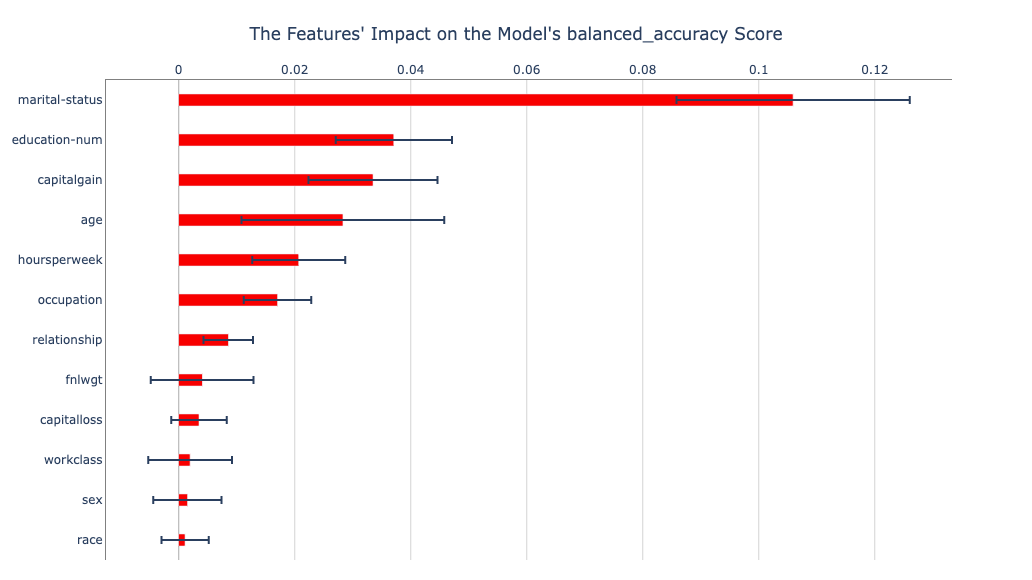

In [29]:
result_explain_model_default.show_in_notebook()

<a id='MLX-dependency'></a>
### Feature Dependence Explanations (PDP + ICE)

Another way to measure dependency on a feature is through a partial dependence plot (PDP) or an individual conditional expectation (ICE) plot. For accumulated local effects (ALE) explanations, see <a href='#MLX-advanced-ale'>Advanced Feature Dependence Options (ALE)</a>

Given a dataset, a PDP displays the average output of the model as a function of the value of the selected set of features. 

It can be computed for a single feature, as in the cell below. The X-axis is the value of the `education-num` feature and the y-axis is the corresponding outputted price. Since we are considering the whole dataset, the average over outputs is given by the red line, while the shaded interval corresponds to a 95% confidence interval for the average.

The histogram on top shows the distribution of the value of the `education-num` feature in the dataset.

In [ ]:
result_explain_feature_dependence_default = explainer.explain_feature_dependence(
    "education-num"
)
result_explain_feature_dependence_default.show_in_notebook()

The ICE plot is automatically computed at the same time as any one-feature PDP. It can be accessed by passing `ice=True` to `show_in_notebook`. 

Similar to PDPs, ICE plots show the median prediction as a model red line. However, the variance in the model's predictions are shown by plotting the predictions of a sample of individual data instances as light grey lines. (For categorical features, the distribution in the predictions is instead shown as a violin plot.)

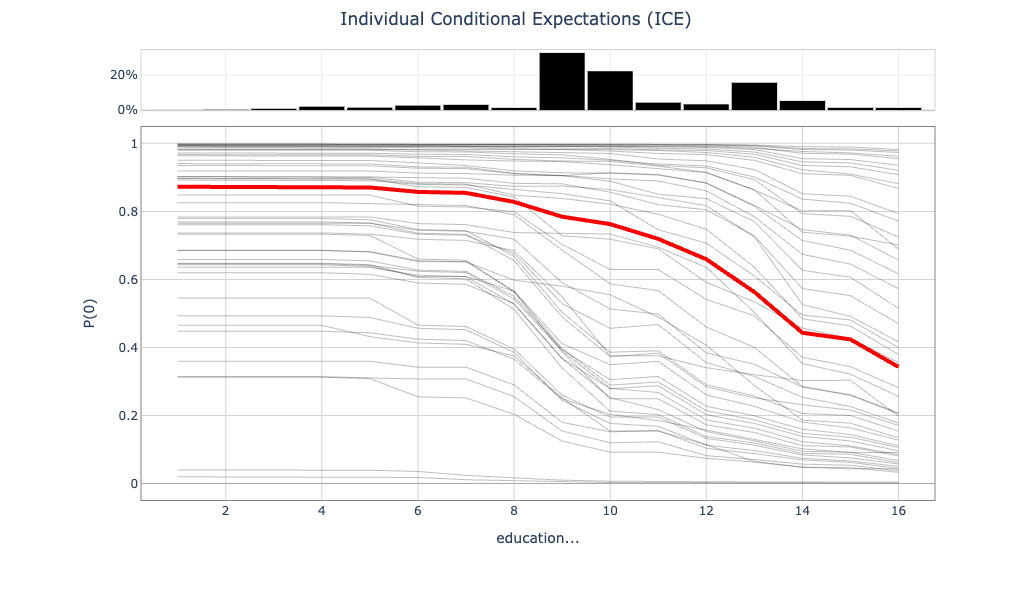

In [31]:
result_explain_feature_dependence_default.show_in_notebook(ice=True)

We can also plot the PDP for up to four features. The plot below is the PDP for the `education-num` and `sex` features. The X-axis still shows the values of `education-num`, while there is a different bar and confidence interval for each value of the feature `sex`.

The histogram displays the joint distribution of the two features.

In [ ]:
result_explain_feature_dependence_default = explainer.explain_feature_dependence(
    ["education-num", "sex"]
)
result_explain_feature_dependence_default.show_in_notebook()

PDPs can be comptued for an arbitrary number of variables; however, they can only be visualized with up to 4. We show an example with 3 below.

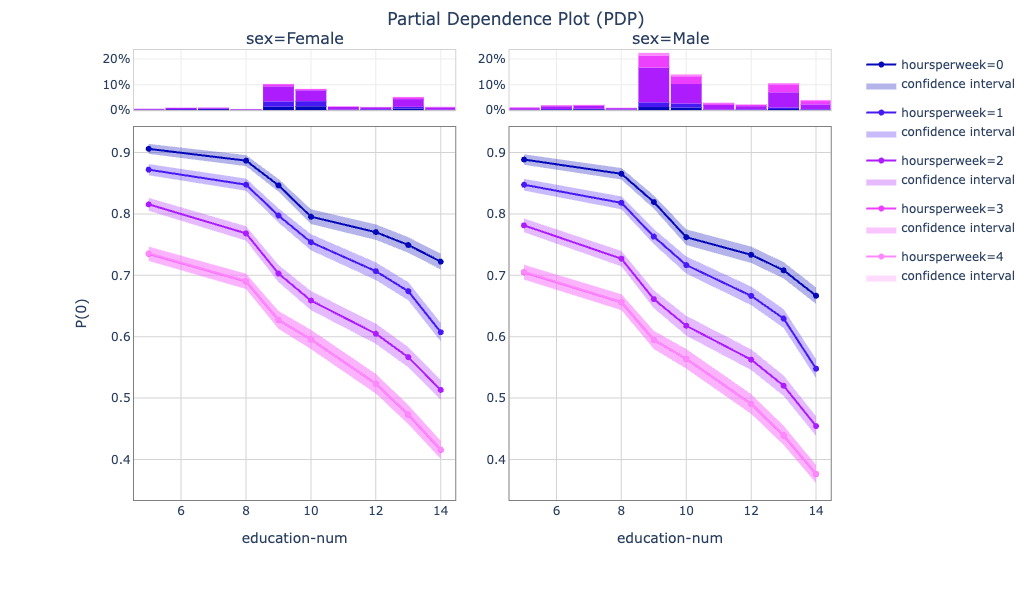

In [ ]:
result_explain_feature_dependence_default = explainer.explain_feature_dependence(
    ["education-num", "hoursperweek", "sex"]
)
result_explain_feature_dependence_default.show_in_notebook()

<a id='MLX-local'></a>
### Prediction Explanations (Local Feature Importance)

Given a data sample, one can also obtain the local importance, which is the importance of the features for the model's prediction on that sample.
In the following cell, we consider sample $10$. The function `explain_prediction()` computes the local importance for a given sample.

`education-num=9.0` means that the value of feature `education-num` for that sample is `9.0`. Removing that feature would change the model's prediction by the magnitude of the bar. That is, in this case, the model's prediction for the probability that the person makes less than 50K is approximately 0.05-0.10 larger because the model knows the value of `education-num` is `9.0`.

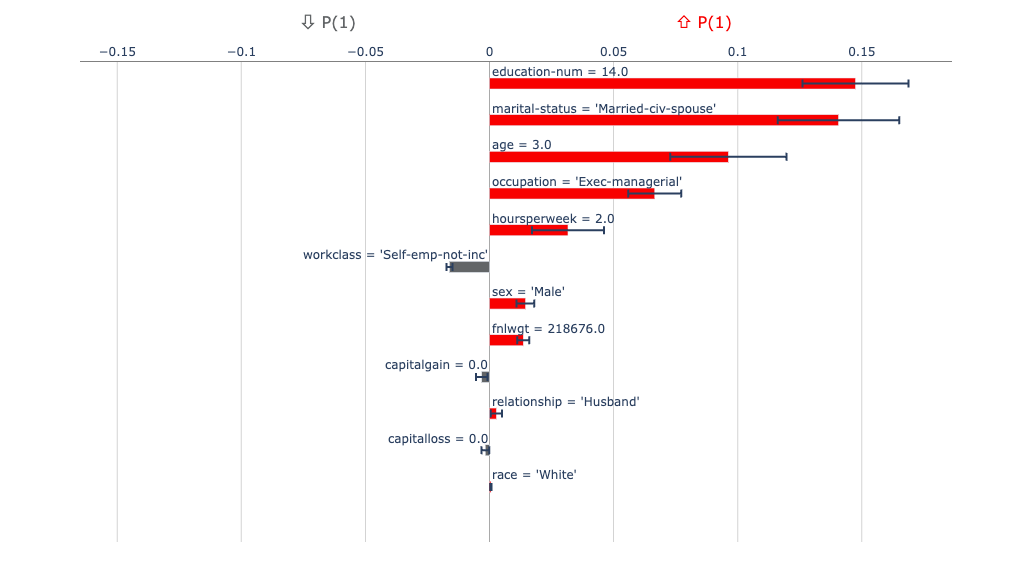

In [34]:
result_explain_prediction_default = explainer.explain_prediction(X_train.sample(n=10))
result_explain_prediction_default[0].show_in_notebook()

<a id='MLX-alfi'></a>
### Aggregate Local Feature Importance
We now summarize all of the individual local feature importance explanations into one single aggregate explanation.

age         workclass    fnlwgt     education  education-num  \
0  3.0  Self-emp-not-inc  218676.0       Masters           14.0   
1  1.0  Self-emp-not-inc  328119.0           9th            5.0   
2  4.0         Local-gov  154171.0  Some-college           10.0   
3  3.0           Private  313146.0       HS-grad            9.0   
4  2.0           Private  312206.0       HS-grad            9.0   
5  3.0         Local-gov  229337.0       HS-grad            9.0   
6  2.0  Self-emp-not-inc  120837.0       HS-grad            9.0   
7  1.0           Private  195994.0  Some-college           10.0   
8  0.0           Private  118023.0       HS-grad            9.0   
9  2.0           Private   62258.0          11th            7.0   

       marital-status         occupation   relationship   race     sex  \
0  Married-civ-spouse    Exec-managerial        Husband  White    Male   
1  Married-civ-spouse       Craft-repair        Husband  White    Male   
2             Widowed  Machine-op-inspct  Not-in-family  White    Male   
3  Married-civ-spouse       Adm-clerical        Husband  White    Male   
4  Married-civ-spouse     Prof-specialty        Husband  White    Male   
5           Separated      Other-service  Not-in-family  White    Male   
6  Married-civ-spouse       Craft-repair        Husband  White    Male   
7       Never-married              Sales  Not-in-family  White  Female   
8       Never-married    Farming-fishing      Own-child  White    Male   
9       Never-married      Other-service  Not-in-family  White  Female   

   capitalgain  capitalloss  hoursperweek native-country  
0          0.0          0.0           2.0  United-States  
1          0.0          0.0           1.0         Mexico  
2          0.0          0.0           0.0  United-States  
3          0.0          0.0           2.0  United-States  
4          0.0          0.0           3.0  United-States  
5          0.0          0.0           2.0  United-States  
6          0.0          3.0           3.0  United-States  
7          0.0          0.0           0.0  United-States  
8          0.0          0.0           1.0  United-States  
9          0.0          0.0           2.0  United-States

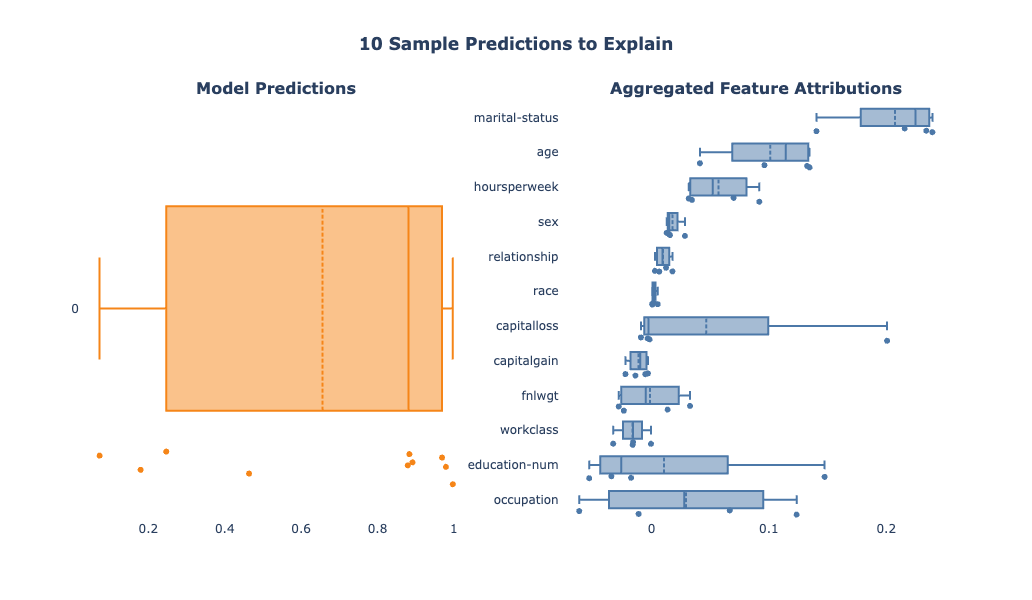

In [35]:
alfi = explainer.aggregate(explanations=result_explain_prediction_default)
alfi.show_in_notebook()

<a id='MLX-whatif'></a>
## Interactive What-If Explainers

The Oracle AutoMLx solution offers also What-IF tool to explain a trained ML model's predictions through a simple interactive interface.

You can use What-IF explainer to explore and visualize immediately how changing a sample value will affect the model's prediction. Forthermore, What-IF can be used to visualize how model's predictions are related to any feature of the dataset.

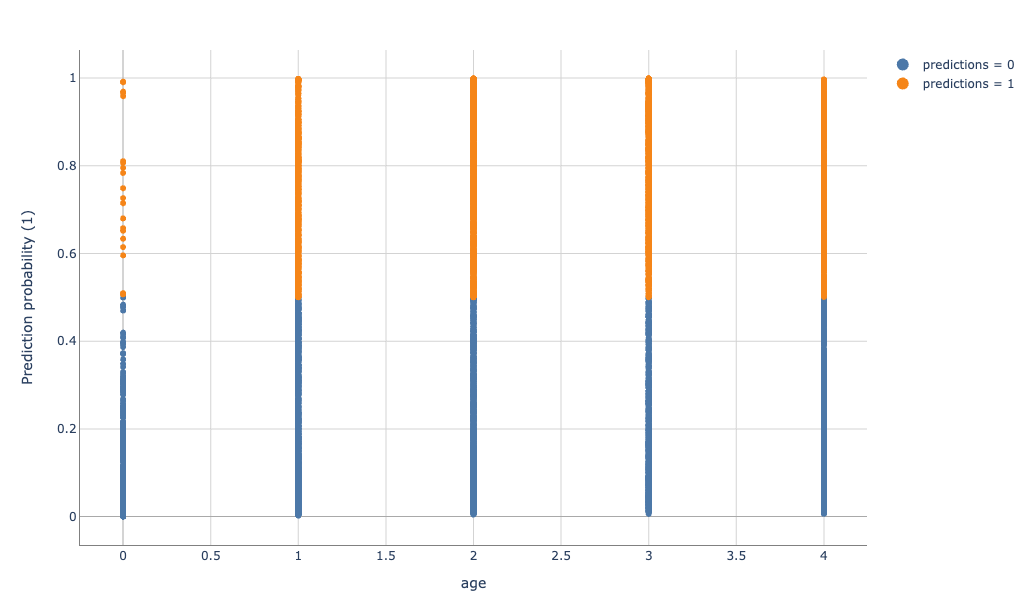

In [36]:
explainer.explore_whatif(X_test, y_test)

<a id='Counterfactuals'></a>
## Counterfactual Explanations

Counterfactual explainers are another set of advanced features that Oracle AutoMLx supports, which help to explain a trained ML model's predictions by identifying the minimal set of changes necessary to flip the model's decision, resulting in a different outcome. To achieve this, the solution frames the explanation process as an optimization problem, similar to adversarial discoveries, while ensuring that the counterfactual perturbations used are feasible and diverse.

With the Oracle AutoMLx solution, users are guaranteed a close to zero-failure rate in generating a set of counterfactual explanations; the explainers might only fail if the reference training set doesn't contain any example with the desired class.
AutoMLx also provides support for simple constraints on features, using `features_to_fix` and `permitted_range`, to ensure the feasibility of the generated counterfactual examples. Additionally, users can use tunable parameters to control the proximity and diversity of the explanations to the original input.

The Oracle AutoMLx solution supports two strategies for creating counterfactual examples. Users can switch between these strategies by setting `strategy` to one of the following options:

- `ace`: The AutoMLx counterfactual explainer introduced by Oracle Labs that uses KDTree structures to find a set of nearest but diverse counterfactuals per sample.

- `dice_random`: This is a tool for creating diverse counterfactual explanations (https://github.com/interpretml/DiCE).

The final results can be returned either through the interactive interface of `What-IF` tools to show the model's prediction sensitivity or static tables and figures.

In [ ]:
explainer.configure_explain_counterfactual(strategy="ace")
explanations = explainer.explain_counterfactual(
    X_test[0:1], n_counterfactuals=3, desired_pred="auto", features_to_fix=["age"]
)
explanations[0].show_in_notebook()

<a id='MLX-advanced'></a>
### Advanced Feature Importance Options

We now show how to use an alternative method for computing feature dependence. Here, we will explain a custom `scikit-learn` model. Note that the MLExplainer object is capable to explain any classification model, as long as the model follows a scikit-learn-style interface with the `predict` and `predict_proba` functions. 

We then create the explainer object.

In [ ]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude=[object, "category"])),
        ("cat", categorical_transformer, selector(dtype_include=[object, "category"])),
    ]
)
scikit_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)


scikit_model.fit(X_train, y_train)

explainer_sklearn = automlx.MLExplainer(
    scikit_model,
    X_train,
    y_train,
    target_names=["<=50K", ">50K"],  # Used for plot labels/legends.
    selected_features="auto",  # These features are used by the model; automatically inferred for AutoML Pipelines,
    task="classification",  # Also supports 'regression' and 'anomaly_detection'
    col_types=None,  # Specify type of features
)

<a id='MLX-including'></a>
#### Include the effects of feature interactions (with Shapley feature importance)

The Oracle AutoMLx solution allows one to change the effect of feature interactions. This can be done through the `tabulator_type` argument of both global and local importance methods. 

`tabulator_type` can be set to one of the following options:
          
- `permutation`: This value is the default method in the MLExplainer object, with the behaviour described above

- `shapley`: Feature importance is computed using the popular game-theoretic Shapley value method. Technically, this measures the importance of each feature while including the effect of all feature interactions. As a result, it runs in exponential time with respect to the number of features in the dataset. This method also includes the interaction effects of the other features, which means that if two features contain duplicate information, they will be less important. Note that the interpretation of this method's result is a bit different from the permutation method's result. An interested reader may find <a href='https://christophm.github.io/interpretable-ml-book/shapley.html'>this</a> a good source for learning more about it.

- `kernel_shap`: Feature importance attributions will be calculated using an approximation of the Shapley value method. It typically provides relatively high-quality approximations; however, it currently does not provide confidence intervals.
            
- `shap_pi`: Feature importance attributions will be computed using an approximation of the Shapley value method. It runs in linear time, but may miss the effect of interactions between some features, which may therefore produce lower-quality results. Most likely, you will notice that this method yields larger confidence intervals than the other two.

**Summary: `permutation` can miss important features for AD. Exact SHAP (`shapley`) doesn't, but it is exponential. `kernel_shap` is an approximation of exact SHAP method that does not provide confidence intervals. `shap_pi` is linear, thus faster than exact SHAP and kernel_shap but unstable and very random leads to lower quality approximations.**

<a id='MLX-advance-tabulator-prediction'></a>
##### Local feature importance with kernel_shap

In this example, we also enable sampling within the explainer to speed up the running time, because kernel SHAP is slower than permutation feature importance. 

In [ ]:
explainer_sklearn.configure_explain_prediction(
    tabulator_type="kernel_shap", sampling={"technique": "random", "n_samples": 2000}
)

<a id='MLX-explain'></a>
#### Explain the model or Explain the world

Oracle AutoMLx solution also provides the `evaluator_type` attribute, which allows one to choose whether to get feature importance attributions that explain exactly which features the model has learned to use (`interventional`), or which features the model or a retrained model could have learned to use (`observational`).
          
- `interventional` : The computed feature importances are as faithful to the
    model as possible. That is, features that are ignored by
    the model will not be considered important. This setting
    should be preferred if the primary goal is to learn about
    the machine learning model itself. Technically, this
    setting is called 'interventional', because the method will
    intervene on the data distribution when assessing the
    importance of features. The intuition of feature importance attributions computed with this method is that the features are dropped from the dataset and the model is not allowed to retrain.

- `observational` : The computed feature importances are more faithful to
    the relationships that exist in the real world (i.e., relationships
    observed in the dataset), even if your specific model did not learn
    to use them. For example, when using a permutation tabulator, a feature
    that is used by the model will not show a large impact on the model's
    performance if there is a second feature that contains near-duplicate
    information, because a re-trained model could have learned to use the
    other feature instead. (Similarly, for Shapley-based tabulators, a 
    feature that is ignored by the model may have a non-zero feature
    importance if it could have been used by the model to
    predict the target.) This setting should be preferred if the
    model is merely a means to learn more about the
    relationships that exist within the data. Technically, this
    setting is called 'observational', because it observes the
    relationships in the data without breaking the existing
    data distribution.

<a id='MLX-advance-evaluator-prediction'></a>
##### Explain the model with observational evaluator_type

In [46]:
explainer_sklearn.configure_explain_model(evaluator_type="observational")

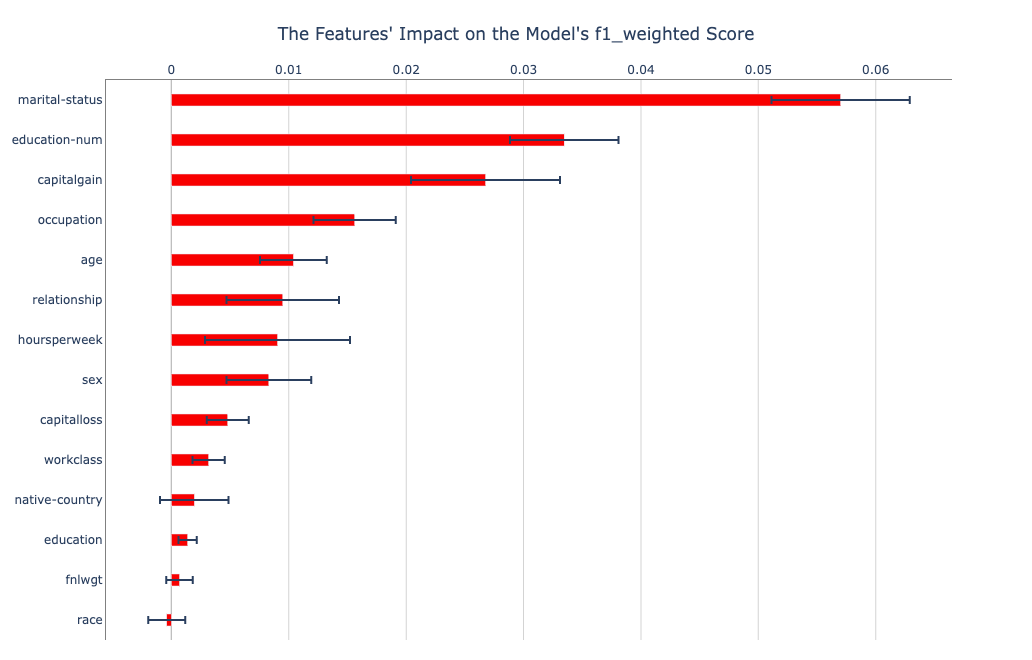

In [47]:
result_explain_model_observational = explainer_sklearn.explain_model()
result_explain_model_observational.show_in_notebook()

<a id='MLX-surrogates'></a>
#### Local feature importance using surrogate models (LIME+)

The Oracle AutoMLx solution allows one to change the type of local explainer effect of feature interactions. This can be done through the `explainer_type` argument of local importance methods. 

`explainer_type` can be set to one of the following options:
          
- `perturbation`: This value is the default explainer type in local feature importance. As we showed above, the explanation(s) will be computed by perturbing the features of the indicated data instance(s) and measuring the impact on the model predictions.

- `surrogate`: The LIME-style explanation(s) will be computed by fitting a surrogate model to the predictions of the original model in a small region around the indicated data instance(s) and measuring the importance of the features to the interpretable surrogate model. The method of surrogate explainer can be set to one of the following options:
  - `systematic`: An Oracle-labs-improved version of LIME that uses a systematic sampling and custom sample weighting. (Default)
  - `lime`: Local interpretable model-agnostic explanations (LIME) algorithm (https://arxiv.org/pdf/1602.04938).

In [ ]:
explainer_sklearn.configure_explain_prediction(
    explainer_type="surrogate", method="lime"
)

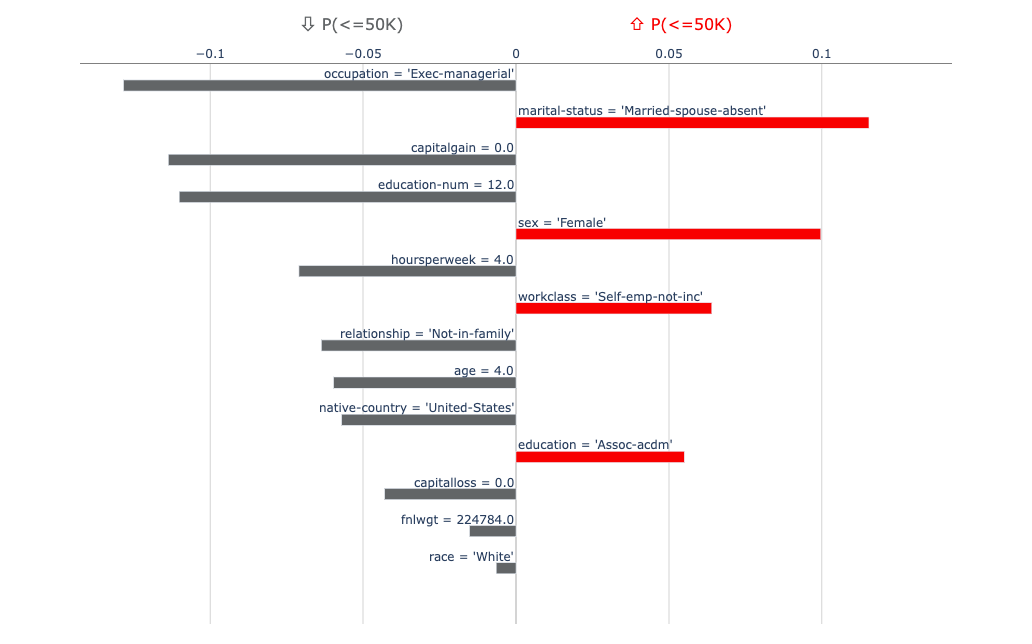

In [ ]:
index = 0
result_explain_prediction_kernel_shap = explainer_sklearn.explain_prediction(
    X_train.iloc[index : index + 1, :]
)
result_explain_prediction_kernel_shap[0].show_in_notebook()

##### Explain predictions with surrogate explainer_type (systematic)

In [ ]:
explainer_sklearn.configure_explain_prediction(
    explainer_type="surrogate", method="systematic"
)

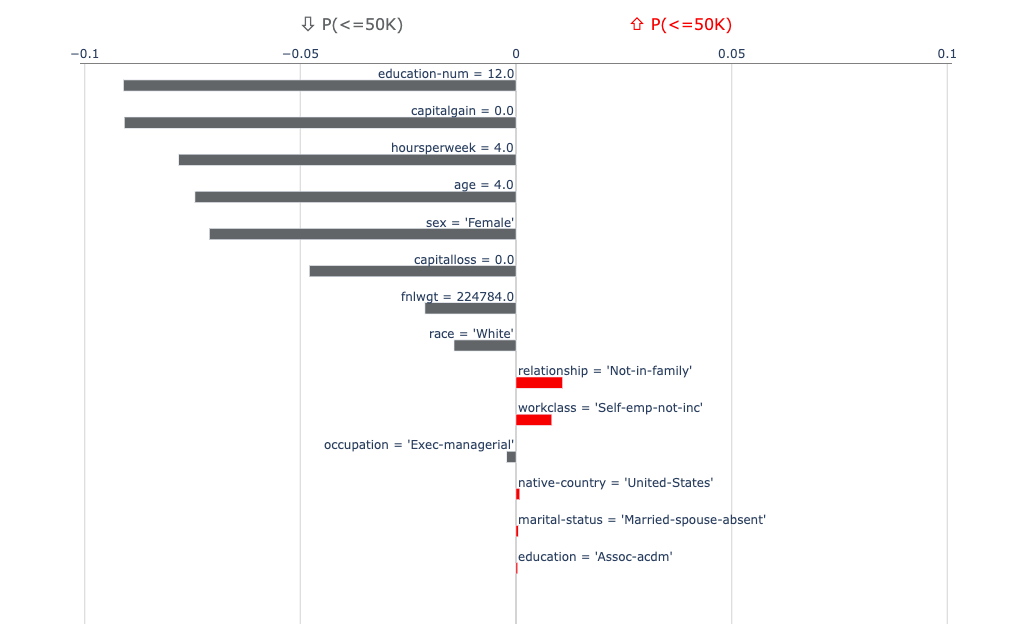

In [ ]:
index = 0
result_explain_prediction_surrogate_systematic = explainer_sklearn.explain_prediction(
    X_train.iloc[index : index + 1, :]
)
result_explain_prediction_surrogate_systematic[0].show_in_notebook()

<a id='MLX-advanced-ale'></a>
### Advanced Feature Dependence Options (ALE)

We now show how to use an alternative method for computing feature dependence: accumulated local effects (ALE). ALE explanations are sometimes considered a better alternative to PDPs when features are correlated, because it does not evaluate the model outside of its training distribution in these cases. For more information, see https://christophm.github.io/interpretable-ml-book/ale.html.

Given a dataset, an ALE displays the average change in the output of the model, accumulated of multiple small changes in one or two features, when all other features are held fixed. By default, the ALE explanations are centered around 0, and thus, unlike PDPs, ALEs show the change in the prediction measured by changing a given feature, rather than the average model's prediction for a particular feature value.

#### One-feature ALEs

It can be computed for a single feature, as in the cell below. The X-axis is the value of the `education-num` feature and the y-axis is the corresponding computed ALE (price unit).

The histogram on top shows the distribution of the value of the `education-num` feature in the dataset.

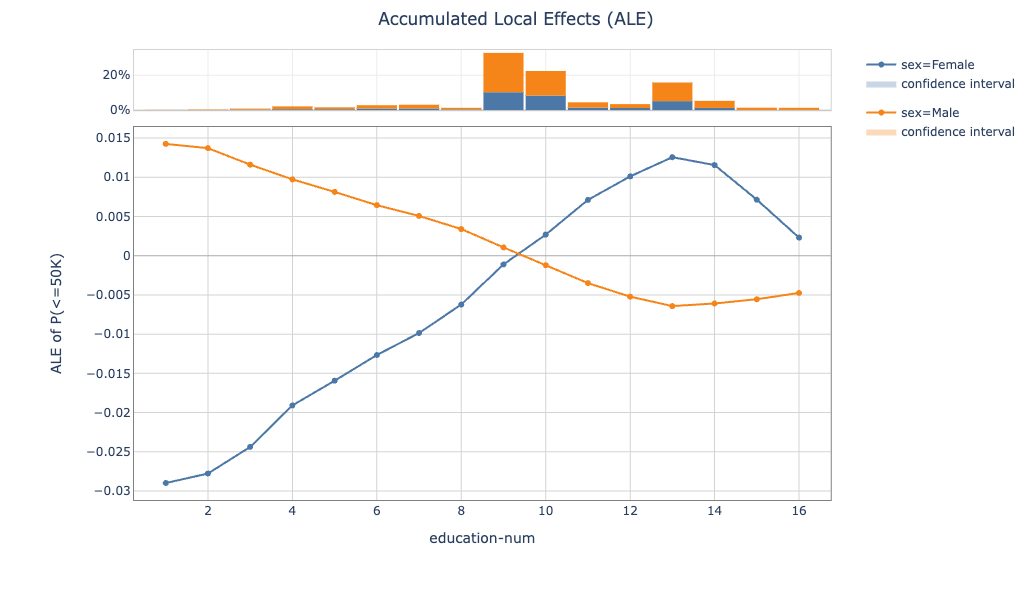

In [ ]:
explainer_sklearn.configure_explain_feature_dependence(explanation_type="ale")
result_explain_feature_dependence_default = (
    explainer_sklearn.explain_feature_dependence(["education-num", "sex"])
)
result_explain_feature_dependence_default.show_in_notebook()

#### Two-feature ALEs

We can also compute ALEs for two features (provided that at least one of them is numerical). The plot below is the ALE plot for the `education-num` and `sex` features. The X-axis still shows the values of `education-num` however, there are now multiple lines, one for each value of the feature `sex`.

The histogram displays the joint distribution of the two features.

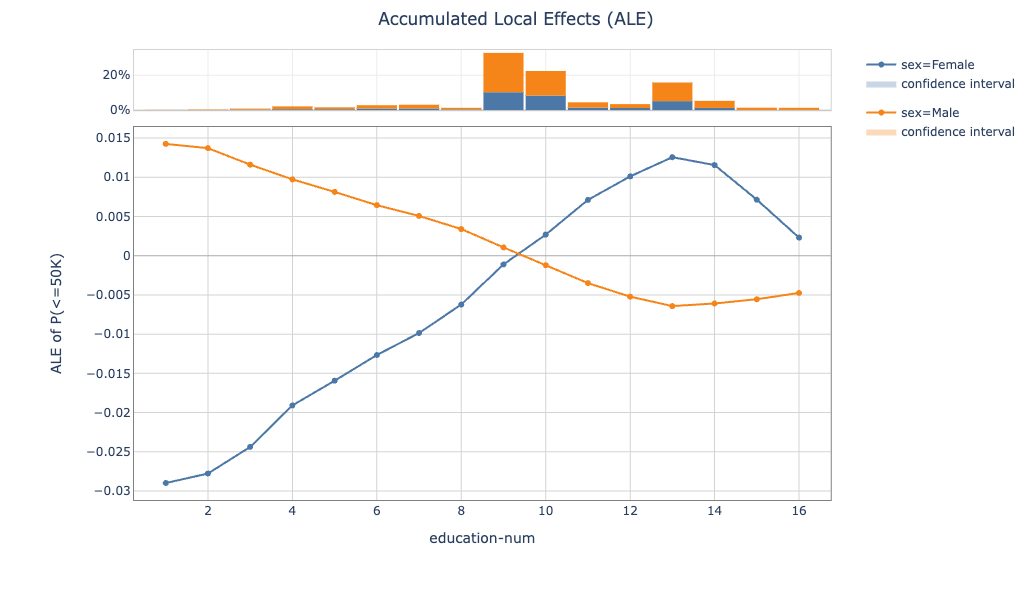

In [ ]:
result_explain_feature_dependence_default = (
    explainer_sklearn.explain_feature_dependence(["education-num", "sex"])
)
result_explain_feature_dependence_default.show_in_notebook()

<a id='ref'></a>
## References
* More examples and details: http://automl.oraclecorp.com/
* Oracle AutoMLx http://www.vldb.org/pvldb/vol13/p3166-yakovlev.pdf
* scikit-learn https://scikit-learn.org/stable/
* Interpretable Machine Learning https://christophm.github.io/interpretable-ml-book/
* LIME https://arxiv.org/pdf/1602.04938
* UCI https://archive.ics.uci.edu/ml/datasets/Adult